### Fist, authenticate to google and import librabies

In [1]:
# ! pip install geemap
# import geemap
import ee
import numpy as np
import pandas as pd
from pprint import pprint
from osgeo import gdal, osr

import matplotlib.pyplot as plt
import seaborn as sns
import plotnine
from plotnine import *

import json
import sys
import glob
import os
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/G_drive')

# cp tokens
!mkdir /root/.config/earthengine/
!cp '/content/G_drive/MyDrive/Colab Notebooks/Google_Earth_Engine_tokes/credentials' /root/.config/earthengine/credentials 

# authenticate earthengine api
ee.Initialize()

# create the tmp folder
! mkdir /content/tf_tmp

Mounted at /content/G_drive


In [3]:
# Cloud authentication.
from google.colab import auth
auth.authenticate_user()

In [4]:
# Tensorflow setup.
import tensorflow as tf
print(tf.__version__)

2.8.0


### Then, difine the basic parameter/path-to-data

In [6]:
# import urban-img and terrain data
urban = ee.Image("users/wangjinzhulala/North_China_Plain_Python/classificatioin_temporal_checked/Mosaic_only_forward")
region = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_Boundary")

In [7]:
# define the year-range
year = [f'{i}_{i+2}' for i in range(1990,2020,3)]
year_img_val_dict = {yr:i for yr,i in zip(year,range(10,0,-1))}

In [12]:
# define the limit_list that controls the periods for prediction
limit_list = [6]

In [9]:
# get all possible years for traning the projection
proj_yr = []
for k,v in year_img_val_dict.items():
    # get the t0 val/img
    t0 = k
        
    # get the t1;t2
    if v == 2:
        pass
    else:
        for val in range(v-1,1,-1):
            prj_val = val - (v - val)
            
            if  prj_val>0:
                
                prj_yr  = [k for k,v in year_img_val_dict.items() if v==prj_val][0]
                
                t1 = [k for k,v in year_img_val_dict.items() if v==val][0]
                t2 = [k for k,v in year_img_val_dict.items() if v==prj_val][0]
                                
                proj_yr.append((t0,t1,t2))

In [14]:
# show the years used for train/pred
proj_yr[limit_list[0]]

('1993_1995', '2002_2004', '2011_2013')

In [ ]:
# Specify feature names and exporting folders
FEATURES   = ['built_up_t0', 'elevation', 'slope', 'built_up_t1']
FEATURES_pred = ['built_up_t1', 'elevation', 'slope', 'built_up_t2']
model_folder = '/content/G_drive/MyDrive/urban_prj_torch/Models'
sample_folder = 'urban_prj_torch_sample'

# Specify the export folder that stores the whole img to be classified
EXPORT_FOLDER = f'/content/G_drive/MyDrive/{sample_folder}'

# Specify the size and shape of patches expected by the model.
KERNEL_SIZE = 256
KERNEL_SHAPE = [KERNEL_SIZE, KERNEL_SIZE]

FEATURES_DICT = {k:tf.io.FixedLenFeature(shape=KERNEL_SHAPE, dtype=tf.float32) for k in  FEATURES}
FEATURES_DICT_pred = {k:tf.io.FixedLenFeature(shape=KERNEL_SHAPE, dtype=tf.float32) for k in FEATURES_pred}

# Sizes of the training and evaluation datasets.
TRAIN_SIZE = 10000
EVAL_SIZE = 2500
PRED_SIZE = 1000

# Specify model training parameters.
BATCH_SIZE = 50
EPOCHS = 10
BUFFER_SIZE = 5000
OPTIMIZER = 'adam'
LOSS = 'MeanSquaredError'
METRICS = ['RootMeanSquaredError']

In [ ]:
# create the training patch

train_data = []

for t in proj_yr:
    
    # get the time
    t0 = t[0]
    t1 = t[1]
    t2 = t[2]
    proj_times = year_img_val_dict[t0] - year_img_val_dict[t1]
    proj_years = proj_times*3
    
    # get the built-up layer
    t0_img,t1_img,t2_img = [urban.gte(year_img_val_dict[yr]).rename(f'built_up_t{i}') for i,yr in enumerate(t)]
    
    # get the expansion mask
    expansion_mask = t1_img.subtract(t0_img).rename('expansion')
    expansion_prj  = t2_img.subtract(t1_img).rename('expansion')
    
    # # import the Distance_to_built-up imgs//  NOTE!!!! currently we only have the road back to 2013
    # Distance_t0 = ee.Image("users/wangjinzhulala/GEE_TF/Distance_imgs/Dist_road_2013").rename('distance')
    # Distance_t1 = ee.Image("users/wangjinzhulala/GEE_TF/Distance_imgs/Dist_road_2016").rename('distance')

    # get the last year to indicate the data of urban image
    year_t0 = ee.Image(int(t0.split('_')[1])).rename('year')
    year_t1 = ee.Image(int(t1.split('_')[1])).rename('year')
    year_t2 = ee.Image(int(t2.split('_')[1])).rename('year')

    # import DEM and SLOPE
    DEM = ee.Image("USGS/SRTMGL1_003")
    SLOPE = ee.Terrain.slope(DEM)
    
    # stack all bands for later tranin/eval
    train_eval_bands = t0_img.addBands(DEM).addBands(SLOPE).addBands(t1_img).select(FEATURES).toFloat()  # IMPORTANT: .toFloat() is necessary!
    pred_bands    = t1_img.addBands(DEM).addBands(SLOPE).addBands(t2_img).select(FEATURES_pred).toFloat()
    # train_eval_bands = t0_img.addBands(DEM).addBands(SLOPE).addBands(Distance_t0).addBands(year_t0).addBands(t1_img).select(FEATURES).toFloat()
    # pred_bands    = t1_img.addBands(DEM).addBands(SLOPE).addBands(Distance_t1).addBands(year_t1).addBands(t2_img).select(FEATURES_pred).toFloat()

    
    # convert img to neighboorhood-array
    list_1d = ee.List.repeat(1, KERNEL_SIZE)
    list_2d = ee.List.repeat(list_1d, KERNEL_SIZE)
    kernel  = ee.Kernel.fixed(KERNEL_SIZE, KERNEL_SIZE, list_2d)

    arrays_train_eval = train_eval_bands.neighborhoodToArray(kernel)
    arrays_pred = pred_bands.neighborhoodToArray(kernel)
    
    # add patch to a dict
    train_data.append([t0,t1,t2,proj_times,proj_years,arrays_train_eval,arrays_pred,pred_bands])

In [ ]:
train_data = pd.DataFrame(train_data,columns = ['t0','t1','t2','proj_times','proj_years','arrays_train_eval','arrays_pred','img_to_proj'])
train_data

,t0,t1,t2,proj_times,proj_years,arrays_train_eval,arrays_pred,img_to_proj
0,1990_1992,1993_1995,1996_1998,1,3,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
1,1990_1992,1996_1998,2002_2004,2,6,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
2,1990_1992,1999_2001,2008_2010,3,9,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
3,1990_1992,2002_2004,2014_2016,4,12,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
4,1993_1995,1996_1998,1999_2001,1,3,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
5,1993_1995,1999_2001,2005_2007,2,6,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
6,1993_1995,2002_2004,2011_2013,3,9,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
7,1993_1995,2005_2007,2017_2019,4,12,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
8,1996_1998,1999_2001,2002_2004,1,3,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
9,1996_1998,2002_2004,2008_2010,2,6,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."


### Step_1: Extract img patches to GCP bucket

#### Export the traning sampel to G-Cloud

In [ ]:
# import the research area, simplify the gemegery to reduce calculation cost
Region = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_Boundary")
Simplified_geo = Region.geometry().simplify(50000)
Simplified_buffer = Simplified_geo.buffer(-15000)

# split the export into patch and shards to avoide "capacity exceed"
total_shards = 1000

# get the patch number
if not MIX_YEAR:
  patch_n = 10
else:
  patch_n = len(train_data)

# get the shard per patch
shard_per_patch = int(total_shards/patch_n)

# set the seed list which is 2-time longer than the toall shards
seed_pool = range(total_shards*2)

In [ ]:
# construc a function to export training samples
def export_sample(img,which_patch,export_type='training'):

  # create an empty to hold the samples
  geomSample = ee.FeatureCollection([])

  for i in range(shard_per_patch):

    # get the seed and sample_size for this patch
    if export_type == 'training':
      seed = seed_pool[which_patch*shard_per_patch + i]
      sample_size = TRAIN_SIZE
    elif export_type == 'eval':
      seed = seed_pool[which_patch*shard_per_patch + i + total_shards]
      sample_size = EVAL_SIZE
    else:
      print('Wrong export type, chose from ["training","eval"]')
      break

    # sample from img
    sample = img.sample(
      region = Simplified_buffer, 
      scale = 30,
      numPixels = int(sample_size/total_shards),
      seed = seed,
      tileScale = 8
    )
    geomSample = geomSample.merge(sample)

  # export the sample
  if MIX_YEAR:
    desc = f"{export_type}_patches_mix_years_{row['t0']}_and_{row['t1']}_prj_{row['t2']}_{which_patch:03}"
  else:
    desc = f"{export_type}_patches_{row['t0']}_and_{row['t1']}_prj_{row['t2']}_{which_patch:03}"

  task = ee.batch.Export.table.toDrive(
      collection = geomSample,
      description = desc,
      folder = sample_folder,
      fileNamePrefix = desc,
      fileFormat = 'TFRecord',
      selectors = FEATURES
  )
  task.start()

  print(desc)

In [ ]:
# export the training and eval samples
for sample_type in ["training","eval"]:

  # check if this was to export sample of mixed-years
  if MIX_YEAR:
    # because we want sample from mixed-year, its better to shuffle the data first
    shuffle_data = train_data.sample(frac=1,random_state=123).reset_index(drop=True)

    # get the training sample
    for idx,row in shuffle_data.iloc[limit_list].iterrows():
      for patch in range(patch_n):
        # export samples  
        img = row['arrays_train_eval']
        export_sample(img,patch,export_type=sample_type)

  else:
    # get the training sample
    for idx,row in train_data.iloc[limit_list].iterrows():
      for patch in range(patch_n):
        # export samples  
        img = row['arrays_train_eval']
        export_sample(img,patch,export_type=sample_type)  

#### Load the data exported from Earth Engine into a tf.data.Dataset. The following are helper functions for that.

In [ ]:
def parse_tfrecord(example_proto,fe_dict):
  """The parsing function.
  Read a serialized example into the structure defined by FEATURES_DICT.
  Args:
    example_proto: a serialized Example.
  Returns:
    A dictionary of tensors, keyed by feature name.
  """
  return tf.io.parse_single_example(example_proto, fe_dict)


def to_tuple(inputs,fe):
  """Function to convert a dictionary of tensors to a tuple of (inputs, outputs).
  Turn the tensors returned by parse_tfrecord into a stack in HWC shape.
  Args:
    inputs: A dictionary of tensors, keyed by feature name.
  Returns:
    A tuple of (inputs, outputs).
  """
  inputsList = [inputs.get(key) for key in fe]
  stacked = tf.stack(inputsList, axis=0)

  return stacked[:len(fe)-1,:,:], stacked[len(fe)-1:,:,:]


def get_dataset(pattern,fe,fe_dict):
  """Function to read, parse and format to tuple a set of input tfrecord files.
  Get all the files matching the pattern, parse and convert to tuple.
  Args:
    pattern: A file pattern to match in a Cloud Storage bucket.
  Returns:
    A tf.data.Dataset
  """
  globs = glob.glob(f"{pattern}*")
  dataset = tf.data.TFRecordDataset(globs, compression_type='GZIP')
  dataset = dataset.map(lambda x: parse_tfrecord(x,fe_dict), num_parallel_calls=2)
  dataset = dataset.map(lambda x: to_tuple(x,fe), num_parallel_calls=2)
  return dataset

Use the helpers to read dataset.

In [ ]:
# parse TFRecord to npy
def TF_to_npy(TRAINING_BASE,EVAL_BASE):

  # parse the TF record
  train_files = f'{EXPORT_FOLDER}/{TRAINING_BASE}*'
  eval_files = f'{EXPORT_FOLDER}/{EVAL_BASE}*'

  train_record = get_dataset(train_files,FEATURES,FEATURES_DICT)
  eval_record = get_dataset(eval_files,FEATURES,FEATURES_DICT)



  # save TFRecord to npy  
  for data,data_type in zip([train_record,eval_record],['train_record','eval_record']):
    # record the smaple index
    idx = 0
    for record in data:

      # get the x-y data
      x = record[0].numpy()
      y = record[1].numpy()

      # combine x-y to a tuple
      x_y_tuple = np.array((x,y))
      if data_type == 'train_record': np.save(f'/content/Sample_npy/{TRAINING_BASE}_{idx:05}.npy',x_y_tuple)
      if data_type == 'eval_record': np.save(f'/content/Sample_npy/{EVAL_BASE}_{idx:05}.npy',x_y_tuple)

      # report the process
      if (idx+1)%500 == 0:
        if data_type == 'train_record': print(f'Saving {data_type}_{idx+1:05}/{TRAIN_SIZE}') 
        if data_type == 'eval_record': print(f'Saving {data_type}_{idx+1:05}/{EVAL_SIZE}') 
      
      # quit when reaching the TRAIN_SIZE
      idx = idx +1
      # if (data_type == 'train_record') and (idx >= TRAIN_SIZE): break
      # elif (data_type == 'eval_record') and (idx >= EVAL_SIZE): break

In [ ]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

#  dataloader class
class MyDataset(Dataset):
  def __init__(self,sample_base):
    self.sample_base = sample_base
    self.sample_npys = glob.glob(f'/content/Sample_npy/{sample_base}*')

  def __len__(self):
    return len(self.sample_npys)

  def __getitem__(self, index):
    data = np.load(self.sample_npys[index],allow_pickle=True)
    return data[0],data[1]

In [ ]:
# convert TFRecord to npy first
for idx,row in train_data.iloc[limit_list].iterrows():

  # get the sample name base
  train_base = f"training_patches_{row['t0']}_and_{row['t1']}_prj_{row['t2']}"
  eval_base = f"eval_patches_{row['t0']}_and_{row['t1']}_prj_{row['t2']}"
  
  # # converting
  # if not os.path.exists('/content/Sample_npy'): os.makedirs('/content/Sample_npy',exist_ok=True)  
  # TF_to_npy(train_base,eval_base)

  # get train & eval loader
  train_loader = DataLoader(MyDataset(train_base),batch_size=40,shuffle=True)
  eval_loader = DataLoader(MyDataset(eval_base),batch_size=40)

### Step_2: Create the CNN model

In [ ]:
import torch
import torch.nn as nn
from torchsummary import summary

model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=3, out_channels=1, init_features=32, pretrained=True)

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [ ]:
# function to evaluate the model
def eval_model(model,loader):

  # set to eval mode
  model.eval()
  
  # compute losses
  losses = []
  with torch.no_grad():
    for batch_idx,data in enumerate(loader):

      # get data, then send them to GPU
      x = torch.FloatTensor(data[0]).to('cuda')
      y = torch.FloatTensor(data[1]).to('cuda')

      # train the model
      score = m(x)

      # compute loss
      loss = creterion(score,y)
      losses.append(loss.cpu().numpy())
 
  # change model back to training mode    
  model.train()

  return losses

In [ ]:
# send model to GPU
m = model.to('cuda')

# set optimizer and creterion
optimizer = torch.optim.Adam(m.parameters())
creterion = torch.nn.MSELoss()

# set the num of epochs
epoch_num = 200

In [ ]:
# Train the model
metrics = {}

for epoch in range(epoch_num):

  for data in tqdm(train_loader):
    
    #______________________Training__________________
    train_losses = []
    # get data, then send them to GPU
    x = torch.FloatTensor(data[0]).to('cuda')
    y = torch.FloatTensor(data[1]).to('cuda')

    # train the model
    score = m(x)

    # back-propagate
    optimizer.zero_grad()
    loss = creterion(score,y)
    optimizer.step()

    # store traning losses
    train_losses.append(loss.detach().cpu().numpy())

  #______________________Evaluation____________________
  eval_loss = eval_model(m,eval_loader)

  # store metrics
  train_losses_mean = np.array(train_losses).mean()
  eval_losses_mean = np.array(eval_loss).mean()

  metrics[('epoch','batch')] = train_losses
  metrics[('epoch','batch')] = eval_loss

  # report the process
  print()
  print('_'.)
  print(f"The loss of {epoch:03} is: Train:{train_losses_mean} Eval:{eval_losses_mean}")

In [ ]:
# construct a function to train the FCNN model with 200 epoches 

def train_fcnn(start_epoch = 1,end_epoch = 20):
  # train the model and save model to disk for each 10-epoches
  for epoch in range(start_epoch,end_epoch + 1):

    # get the name
    if MIX_YEAR and YEAR:
      name = f'FCNN_mix_years'
      TRAINING_BASE = f"training_patches_mix_years"
      EVAL_BASE = f"eval_patches_mix_years"
    elif MIX_YEAR:
      name = f'FCNN_mix_years'
      TRAINING_BASE = f"training_patches_mix_no_years"
      EVAL_BASE = f"eval_patches_mix_no_years"
    else:
      TRAINING_BASE = f"training_patches_{row['t0']}_and_{row['t1']}_prj_{row['t2']}"
      EVAL_BASE = f"eval_patches_{row['t0']}_and_{row['t1']}_prj_{row['t2']}"
      name = f'FCNN_{row["t0"]}_and_{row["t1"]}_prj_{row["t2"]}'
    

    # get the pre-trained model
    if epoch == 1:
      m = model.to('cuda')
    else:
      m = tf.keras.models.load_model(f'{model_folder}/{name}_{(epoch-1)*10:03}.pb')

    # get the train data
    training = get_training_dataset(TRAINING_BASE).repeat()
    # get the eval data
    evaluation = get_eval_dataset(EVAL_BASE).repeat()

    # fit the model
    print(f"Training model for {name}_{epoch*10:03}")
    m.fit(
        x=training, 
        epochs=10,
        steps_per_epoch=int(TRAIN_SIZE/BATCH_SIZE),
        validation_data = evaluation,
        validation_steps = EVAL_SIZE)

    # save the training history
    loss = pd.DataFrame(m.history.history)
    loss.to_csv(f"{model_folder}_metrics_csv/{name}_{epoch*10:03}.csv",index=False)

    # save/load model
    m.save(f"{model_folder}/{name}_{epoch*10:03}.pb")

    print('_______________________________________')


In [ ]:
# if we are training model with the mix-year samples, we start the training directly
if MIX_YEAR:
  print('='.center(80,'='))
  print(' Training model of mix-year '.center(80,'='))
  print('='.center(80,'='))
  train_fcnn()

# if we are not train the model with mix-year samples, we will locate the year by 
# examine the index of the data-df, then train the model  
else:
  print('='.center(80,'='))
  print('Training model of non-mix-year'.center(80,'='))
  print('='.center(80,'='))

  # export traning sample
  for idx,row in train_data.iterrows():
    # define the condition to avoide export all samples
    if idx in limit_list:
      # train the fcnn with 200 epoches
      train_fcnn()

===========================Training model of mix-year===========================
Training model for FCNN_1999_2001_and_2008_2010_prj_2017_2019_010
Epoch 1/10
200/200 [==============================] - 227s 896ms/step - loss: 0.0810 - root_mean_squared_error: 0.2847 - val_loss: 0.1414 - val_root_mean_squared_error: 0.3761
Epoch 2/10
200/200 [==============================] - 193s 852ms/step - loss: 0.0341 - root_mean_squared_error: 0.1845 - val_loss: 0.1796 - val_root_mean_squared_error: 0.4238
Epoch 3/10
200/200 [==============================] - 193s 852ms/step - loss: 0.0291 - root_mean_squared_error: 0.1707 - val_loss: 0.0404 - val_root_mean_squared_error: 0.2010
Epoch 4/10
200/200 [==============================] - 193s 852ms/step - loss: 0.0274 - root_mean_squared_error: 0.1657 - val_loss: 0.0660 - val_root_mean_squared_error: 0.2568
Epoch 5/10
200/200 [==============================] - 193s 851ms/step - loss: 0.0272 - root_mean_squared_error: 0.1649 - val_loss: 0.0309 - val_root_

#### Check the losses change

In [ ]:
df_no_distance =  ! ls /content/G_drive/MyDrive/Urban_prj_models/FCNN_models_mix_no_year_metrics_csv/*
df_with_distance = ! ls /content/G_drive/MyDrive/Urban_prj_models/FCNN_models_mix_year_metrics_csv/*

In [ ]:
df_no_distance

['/content/G_drive/MyDrive/Urban_prj_models/FCNN_models_mix_no_year_metrics_csv/FCNN_mix_years_010.csv',
 '/content/G_drive/MyDrive/Urban_prj_models/FCNN_models_mix_no_year_metrics_csv/FCNN_mix_years_020.csv',
 '/content/G_drive/MyDrive/Urban_prj_models/FCNN_models_mix_no_year_metrics_csv/FCNN_mix_years_030.csv',
 '/content/G_drive/MyDrive/Urban_prj_models/FCNN_models_mix_no_year_metrics_csv/FCNN_mix_years_040.csv',
 '/content/G_drive/MyDrive/Urban_prj_models/FCNN_models_mix_no_year_metrics_csv/FCNN_mix_years_050.csv',
 '/content/G_drive/MyDrive/Urban_prj_models/FCNN_models_mix_no_year_metrics_csv/FCNN_mix_years_060.csv',
 '/content/G_drive/MyDrive/Urban_prj_models/FCNN_models_mix_no_year_metrics_csv/FCNN_mix_years_070.csv',
 '/content/G_drive/MyDrive/Urban_prj_models/FCNN_models_mix_no_year_metrics_csv/FCNN_mix_years_080.csv',
 '/content/G_drive/MyDrive/Urban_prj_models/FCNN_models_mix_no_year_metrics_csv/FCNN_mix_years_090.csv',
 '/content/G_drive/MyDrive/Urban_prj_models/FCNN_models

In [ ]:
df_no_dist = pd.concat([pd.read_csv(f) for f in df_no_distance])
df_no_dist['type'] = 'No_dist'
df_no_dist['epoch'] = range(1,len(df_no_dist)+1)

df_with_dist = pd.concat([pd.read_csv(f) for f in df_with_distance])
df_with_dist['type'] = 'With_dist'
df_with_dist['epoch'] = list(range(1,len(df_with_dist)+1))

In [ ]:
df = pd.concat([df_no_dist,df_with_dist])
df = df[df['epoch']%10==0]

/usr/local/lib/python3.7/dist-packages/plotnine/stats/smoothers.py:168: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  "for lowess smoothings.", PlotnineWarning)


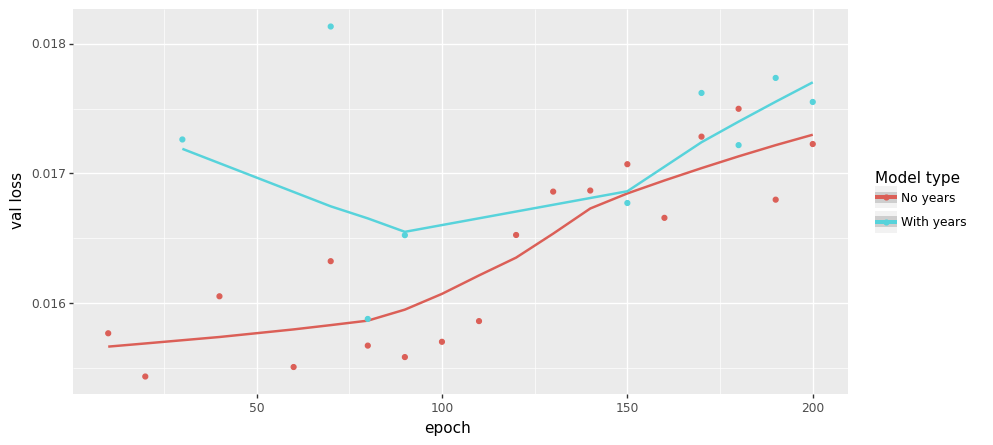

<ggplot: (8756538512289)>

In [ ]:
plotnine.options.figure_size = (10, 5)

(df[df['val_loss']<0.020] >> 
 ggplot()+
 geom_smooth(aes('epoch','val_loss',color='type'),se=True, size=1)+
 geom_point(aes('epoch','val_loss',color='type')) +
 scale_x_continuous(breaks = range(0,501,50)) +
 scale_color_hue(name="Model type",labels =['No years','With years']) +
 ylab('val loss') 
 
 )

#### Explore the results

In [ ]:
# # get the sample patchs
# pred_patch = m.predict(pred_tf.take(PRED_SIZE))
# true_patch = [i[1].numpy() for i in  iter(pred_tf.take(PRED_SIZE))]

# # plot randomly one of the patches
# num = np.random.randint(PRED_SIZE)

# plt.figure(figsize=(6,6))
# plt.imshow(pred_patch[num,:,:,0])

# true = true_patch[num]
# plt.figure(figsize=(6,6))
# plt.imshow(true[0,:,:,0])

### Step_3: Export the GEE-asset to Cloud-Storage as TF format, and make predictions

#### Export the gee-asset to tf-format, note the buffer

In [ ]:
region = ee.Feature(ee.Geometry.Polygon(
        [[[115.12664527404763, 34.81907241078023],
          [115.12664527404763, 33.80730649645679],
          [116.47796363342263, 33.80730649645679],
          [116.47796363342263, 34.81907241078023]]]))

In [ ]:
# a helper function to export tif to TF
def doExport(img,out_image_base, kernel_buffer, region):
  """Run the image export task.  Block until complete.
  """
  task = ee.batch.Export.image.toDrive(
      image = img.select(FEATURES_pred[:-1]).toFloat(),
      description = out_image_base,
      folder = sample_folder,
      fileNamePrefix = out_image_base,
      region = region.geometry().bounds(),
      scale = 30,
      fileFormat = 'TFRecord',
      maxPixels = 1e10,
      formatOptions = {
        'patchDimensions': KERNEL_SHAPE,
        'kernelSize': kernel_buffer,
        'compressed': True,
        'maxFileSize': 104857600
    }
  )
  task.start()

#### Perform prediction/classification

In [ ]:
def doPrediction(model,out_image_base, user_folder, kernel_buffer, pred_chunk_num):
  """Perform inference on exported imagery, upload to Earth Engine.
  """

  print('Looking for TFRecord files...')

  # Get a list of all the files in the output bucket.
  filesList = !ls {EXPORT_FOLDER}

  # Get only the files generated by the image export.
  exportFilesList = [s for s in filesList if pred_image_base in s]

  # Get the list of image files and the JSON mixer file.
  imageFilesList = []
  jsonFile = None
  for f in exportFilesList:
    if f.endswith('.tfrecord.gz'):
      imageFilesList.append(f'{EXPORT_FOLDER}/{f.strip()}')
    elif f.endswith('.json'):
      jsonFile = f'{EXPORT_FOLDER}/{f.strip()}'

  # Make sure the files are in the right order.
  imageFilesList.sort()

  from pprint import pprint
  pprint(imageFilesList)
  print(jsonFile)

  import json
  # Load the contents of the mixer file to a JSON object.
  jsonText = !cat {jsonFile}
  # Get a single string w/ newlines from the IPython.utils.text.SList
  mixer = json.loads(jsonText.nlstr)
  pprint(mixer)
  patches = mixer['totalPatches']

  # Get set up for prediction.
  x_buffer = int(kernel_buffer[0] / 2)
  y_buffer = int(kernel_buffer[1] / 2)

  buffered_shape = [
      KERNEL_SHAPE[0] + kernel_buffer[0],
      KERNEL_SHAPE[1] + kernel_buffer[1]]

  imageFeaturesDict = { k:tf.io.FixedLenFeature(shape=buffered_shape, dtype=tf.float32) for k in FEATURES_pred[:-1] }
  

  def parse_image(example_proto):
    return tf.io.parse_single_example(example_proto, imageFeaturesDict)

  def toTupleImage(inputs):
    inputsList = [inputs.get(key) for key in FEATURES_pred[:-1]]
    stacked = tf.stack(inputsList, axis=0)
    stacked = tf.transpose(stacked, [1, 2, 0])
    return stacked

  # Create a dataset from the TFRecord file(s)
  imageDataset = tf.data.TFRecordDataset(imageFilesList, compression_type='GZIP')
  imageDataset = imageDataset.map(parse_image, num_parallel_calls=5)
  imageDataset = imageDataset.map(toTupleImage).batch(1)



  # Perform inference. Note split the imageDataset to chunks to avoid memory explosion
  out_image_file = f'/content/tf_tmp/{out_image_base}.TFRecord'
  writer = tf.io.TFRecordWriter(out_image_file)

  for start in range(0,patches,pred_chunk_num):
    
    # find out the slicing point
    slicing_pt = f'{start:05d}_{min(start + pred_chunk_num, patches):05d}'

    # slice a chunk from imageDataset
    in_pred = imageDataset.skip(start).take(pred_chunk_num)
    print(f'Running predictions {slicing_pt}')

    # make the prediction/classification
    predictions = model.predict(in_pred, steps=pred_chunk_num, verbose=1)

    flag = 1
    for predictionPatch in predictions:
      
      predictionPatch = predictionPatch[
          x_buffer:x_buffer+KERNEL_SIZE, y_buffer:y_buffer+KERNEL_SIZE]

      # Create an example.
      example = tf.train.Example(
        features=tf.train.Features(
          feature={
            'pred': tf.train.Feature(
                float_list=tf.train.FloatList(
                    value=predictionPatch.flatten()))
          }
        )
      )
      # Write the example.
      writer.write(example.SerializeToString())

      # report the process
      if flag % 1000 == 0:
        print(f'Writing patch {slicing_pt}_{flag:04d}')
      flag += 1

  writer.close() 

In [ ]:
# Output assets folder
user_folder = 'users/wangjinzhulala/GEE_TF/Urban_projection'
# Half this will extend on the sides of each patch.
pred_kernel_buffer = [32, 32]
# Define the export_region
export_region = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_Boundary") 

# define the number of chunks to be splited from the tf file
chunk_num = 3

In [ ]:
# First, we need to export all img to disk
for idx,row in train_data.iterrows():

  # define the condition to avoide export all samples
  if idx in limit_list:

    # Define basic parameters
    pred_image_base = f'FCNN_{row["t0"]}_and_{row["t1"]}_prj_{row["t2"]}'
    pred_image = row['img_to_proj']

    # Export
    doExport(pred_image, pred_image_base, pred_kernel_buffer, export_region)

    # print out the process
    print(f'Exporting {pred_image_base}')

Exporting FCNN_2011_2013_and_2014_2016_prj_2017_2019


### Step_4: Save the tf_Record to geotif

In [ ]:
# function to read tf_data and extract the np.array
def tf_to_arry(tf_data,skip_row,take_row):

  # loop through tf_data to get np.array
  img_array = []
  for fe in tf_data.skip(width*skip_row).take(width*take_row):

    arry = fe['pred'].numpy()
    img_array.append(arry)

  # rearrange the np.array to a 2-d image
  out_array = np.array(img_array)
  img_array = None
  out_array = out_array.reshape(take_row,-1,256,256)
  out_array = list(map(lambda x:np.hstack(x),out_array))
  out_array = np.array(np.vstack(out_array))

  # convert the out_array to int-16 to reduce space
  out_array = (out_array*10000).astype(np.int16)

  # print out the memory that the array takes
  print(f'Memory taking: {out_array.nbytes/1024/1024/1024:.2f} GB')

  return out_array

In [ ]:
def arry_to_geotif(in_arry,tif_name,skip_row):
  # fetch the projection
  sr = osr.SpatialReference()
  sr.ImportFromEPSG(epsg)
  sr_wtk = sr.ExportToWkt()

  # get the transformation info
  proj = mixer['projection']['affine']['doubleMatrix']
  delta_x = proj[0]
  start_X = proj[2]
  delta_y = proj[-2]
  start_Y = proj[-1] + KERNEL_SIZE * delta_y * skip_row

  # initiate raster driver
  driver = gdal.GetDriverByName('GTiff')
  driver.Register()

  # create empty raster with proj and geo_transformation
  outds = driver.Create(tif_name,xsize=in_arry.shape[1],ysize=in_arry.shape[0],
              bands=1,eType=gdal.GDT_Int16)
  outds.SetGeoTransform([start_X,delta_x,0,start_Y,0,delta_y])
  outds.SetProjection(sr_wtk)

  # writh array to rasterband
  outband = outds.GetRasterBand(1)
  outband.WriteArray(in_arry)
  outband.SetNoDataValue(-1)
  outband.FlushCache()

  outds = None
  outband = None
  in_arry = None

In [ ]:
# Make predictions using the FCNN model

for idx,row in train_data.iterrows():

  # define the condition to avoide export all samples
  if idx in limit_list:

    # loop through each 10-epoches trained model
    for e in [2]: # range(1,EPOCHS+1)

      # get the name
      if MIX_YEAR:
        name = f'FCNN_mix_years'
      else:
        name = f'FCNN_{row["t0"]}_and_{row["t1"]}_prj_{row["t2"]}'

      # import the model
      epoch = e*10
      model = tf.keras.models.load_model(f'{model_folder}/{name}_{epoch:03}.pb')


      #__________________________copy the tf to local disk and make inferences using the FCNN model_____________________

      # Base file name to use for TFRecord files and assets.
      pred_image_base = f'FCNN_{row["t0"]}_and_{row["t1"]}_prj_{row["t2"]}'

      # Run the prediction.
      doPrediction(model, pred_image_base, user_folder, pred_kernel_buffer, 20000)


      #________________________________________Save the tf to geo-tif______________________________________________________
      # parse tf_record
      pred_dict = { 'pred':tf.io.FixedLenFeature(shape=KERNEL_SHAPE, dtype=tf.float32)}
      pred_img_tf = tf.data.TFRecordDataset(f'/content/tf_tmp/{pred_image_base}.TFRecord')
      pred_img_tf = pred_img_tf.map(lambda fe: tf.io.parse_single_example(fe, pred_dict))

      # get geo-spatial infomation from the mixer.json file
      jsonText = ! cat {EXPORT_FOLDER}/{pred_image_base}*mixer.json
      mixer = json.loads(jsonText.nlstr)
      pprint(mixer)

      # get meta-info from mixer file
      total_patch = mixer['totalPatches']
      width = mixer['patchesPerRow']
      hight = int(total_patch/width)

      # get the EPSG number
      epsg = mixer['projection']['crs']
      epsg = int(epsg.strip('EPSG:'))

      # split the tf_data to chunks accordint to its hight (row_num), then export the tif
      chunk = chunk_num
      idx = np.arange(hight)

      # convert tf_data to tif, then export
      for i,idx_arry in enumerate(np.array_split(idx,chunk)):
        skip_num = idx_arry[0]
        take_num = len(idx_arry)

        print(f'Start row: {skip_num }')
        print(f'End row: {skip_num + take_num}')

        out_array = tf_to_arry(pred_img_tf,skip_num,take_num)
        arry_to_geotif(out_array,f'{pred_image_base}_{i:02}.tif',skip_num)  
        out_array = None
      
        print(f'exporting {pred_image_base}_{i:02}.tif')
        print('______________________________________')
        print()




      #________________________________________Upload geo-tif to gee-asset______________________________________________________

      # get the name
      if MIX_YEAR and YEAR:
        model_type = 'mix_years'
      elif MIX_YEAR:
        model_type = 'mix_no_years'
      elif ROAD:
        model_type = 'with_distance'
      else:
        model_type = 'no_distance'

      # upload from Colab to Gstore.
      ! gsutil -m cp '/content/'{pred_image_base}'_*.tif' gs://tf-gee/Urban_projection/

      # create an empty imageCollection
      ! earthengine create collection users/wangjinzhulala/GEE_TF/Urban_projection/{pred_image_base}_{model_type}_{epoch}

      # create the upload cmd txt
      with open("tmp.txt", "w") as text_file:
        for i in range(chunk_num):
          text_file.write(f"earthengine upload image --asset_id=users/wangjinzhulala/GEE_TF/Urban_projection/{pred_image_base}_{model_type}_{epoch}/{pred_image_base}_{i:02} gs://tf-gee/Urban_projection/{pred_image_base}_{i:02}.tif\n")

      # excute the cmd
      ! bash tmp.txt

      # delete all tmp files
      ! rm -r /content/{pred_image_base}*